### To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import matplotlib.pyplot as plt
from scipy.stats import variation
import warnings
from statsmodels.stats.anova import AnovaRM
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

## Dataframe Setup

In [233]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = [83, 20, 179, 178, 175, 'p08', 'p09', 'p10', 'p11'] 

In [329]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'Bigram #': 'bigram_num'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes
corr_trials = all_trials[all_trials.string == all_trials.resp_string]
incorr_trials = all_trials[all_trials.string != all_trials.resp_string]

corr_bgs = typ.correct_filter(all_bigrams) ## only correct trials
incorr_bgs = typ.incorrect_filter(all_bigrams) ## only incorrect trials

corr_rts = typ.rt_columns(corr_trials) ## only correct rts
incorr_rts = typ.rt_columns(incorr_trials) ## only incorrect rts

## making filtered dataframes by word frequency
highwf_df = all_trials[all_trials['string'].isin(typ.highwf)]
medwf_df = all_trials[all_trials['string'].isin(typ.medwf)]
lowwf_df = all_trials[all_trials['string'].isin(typ.lowwf)]
pseudo_df = all_trials[all_trials['string'].isin(typ.pseudo)]

## making filtered dataframes by bigram frequency
highbf_df = all_trials[all_trials['string'].isin(typ.highbf)]
medbf_df = all_trials[all_trials['string'].isin(typ.medbf)]
lowbf_df = all_trials[all_trials['string'].isin(typ.lowbf)]

## making dataframes with rts by word frequency type
highwf_rts = (typ.rt_columns(highwf_df)).reset_index(drop=True)
medwf_rts = (typ.rt_columns(medwf_df)).reset_index(drop=True)
lowwf_rts = (typ.rt_columns(lowwf_df)).reset_index(drop=True)
pseudo_rts = (typ.rt_columns(pseudo_df)).reset_index(drop=True)

## making dataframes with rts by bigram frequency type
highbf_rts = (typ.rt_columns(highbf_df)).reset_index(drop=True)
medbf_rts = (typ.rt_columns(medbf_df)).reset_index(drop=True)
lowbf_rts = (typ.rt_columns(lowbf_df)).reset_index(drop=True)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_bgs[corr_bgs.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])

## Variables by Word and Word Type (WF and BF)

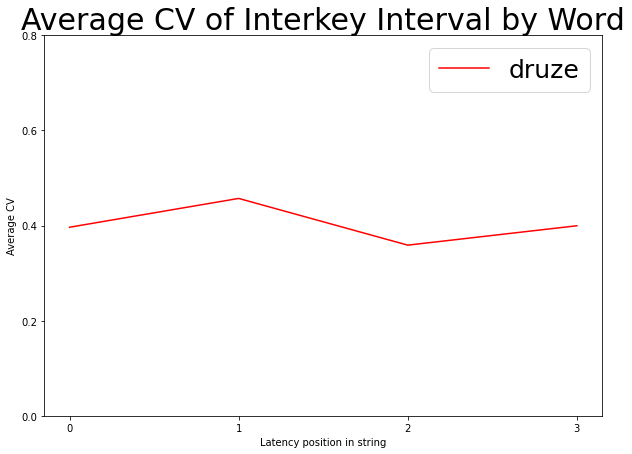

In [4]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'druze' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

## Set general font size
plt.rcParams['font.size'] = '25'

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word")
plt.legend(loc="best")

plt.show()

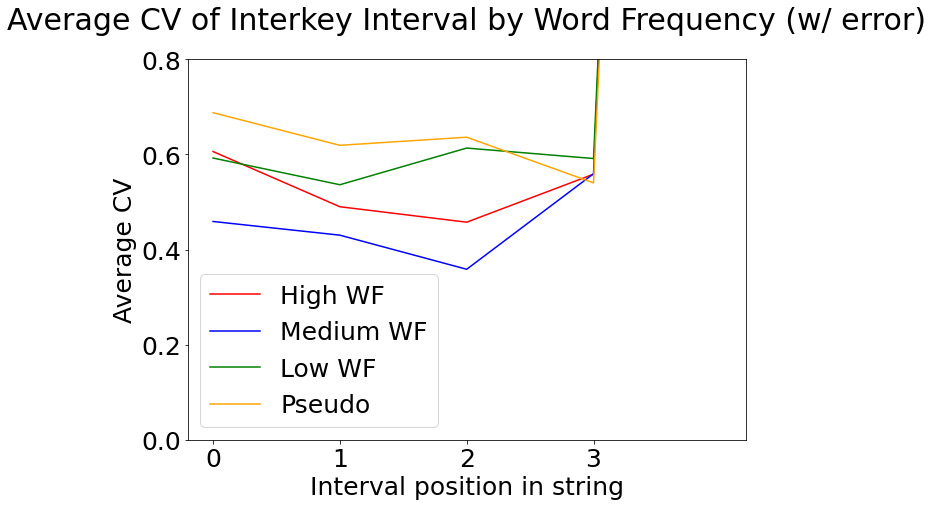

In [521]:
## plotting digraph latency variations by WF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

## Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
plt.legend(loc="best")

# plt.savefig('ian_iki.png')

plt.show()

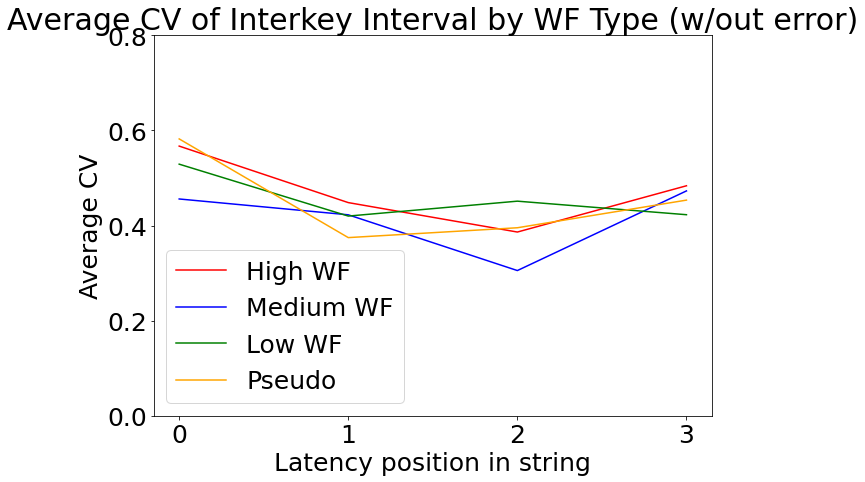

In [6]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
plt.legend(loc="best")

plt.show()

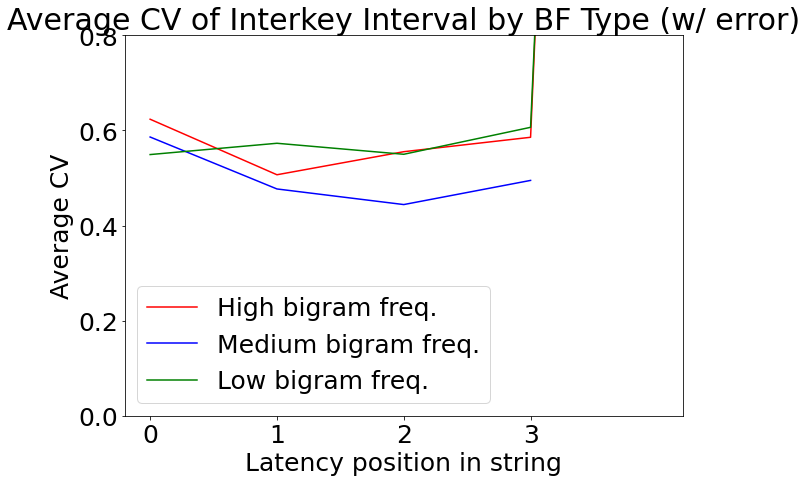

In [7]:
## plotting digraph latency variations by BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, all_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, all_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, all_rts), color='green', label='Low bigram freq.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/ error)")
plt.legend(loc="best")

plt.show()

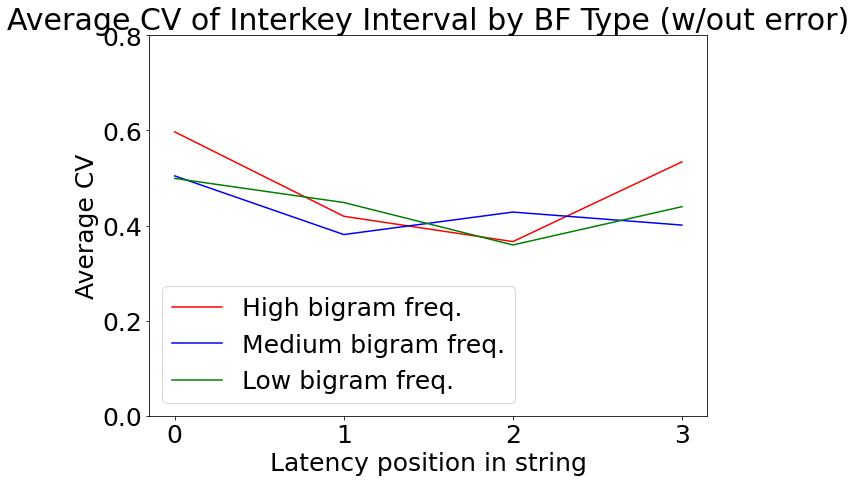

In [8]:
## plotting digraph latency variations by BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, corr_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, corr_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/out error)")
plt.legend(loc="best")

plt.show()

In [9]:
# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('IKI Distribution by WF', y=0.95)

# axs[0, 0].boxplot((typ.iki(highwf_rts)).loc[:, 0:3])
# axs[0, 0].set_title("High WF")
# # axs[0, 0].set_median(linewidth = 3)
# # axs[0, 0].set_ylim([-0.01, 1])
# axs[0, 1].boxplot((typ.iki(medwf_rts)).loc[:, 0:3])
# axs[0, 1].set_title("Med WF")
# # axs[0, 1].set_ylim([-0.01, 1])
# axs[1, 0].boxplot((typ.iki(lowwf_rts)).loc[:, 0:3])
# axs[1, 0].set_title("Low WF")
# # axs[1, 0].set_ylim([-0.01, 1])
# axs[1, 1].boxplot((typ.iki(pseudo_rts)).loc[:, 0:3])
# axs[1, 1].set_title("Pseudo")
# # axs[1, 1].set_ylim([-0.01, 1])

# for ax in axs.flat:
#     ax.set(ylabel='IKI (s)', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [10]:
highwf_ikis = pd.concat([typ.iki(highwf_rts)[0], typ.iki(highwf_rts)[1], typ.iki(highwf_rts)[2], typ.iki(highwf_rts)[3]], axis=0, ignore_index=True)
medwf_ikis = pd.concat([typ.iki(medwf_rts)[0], typ.iki(medwf_rts)[1], typ.iki(medwf_rts)[2], typ.iki(medwf_rts)[3]], axis=0, ignore_index=True)
lowwf_ikis = pd.concat([typ.iki(lowwf_rts)[0], typ.iki(lowwf_rts)[1], typ.iki(lowwf_rts)[2], typ.iki(lowwf_rts)[3]], axis=0, ignore_index=True)
pseudo_ikis = pd.concat([typ.iki(pseudo_rts)[0], typ.iki(pseudo_rts)[1], typ.iki(pseudo_rts)[2], typ.iki(pseudo_rts)[3]], axis=0, ignore_index=True)

highbf_ikis = pd.concat([typ.iki(highbf_rts)[0], typ.iki(highbf_rts)[1], typ.iki(highbf_rts)[2], typ.iki(highbf_rts)[3]], axis=0, ignore_index=True)
medbf_ikis = pd.concat([typ.iki(medbf_rts)[0], typ.iki(medbf_rts)[1], typ.iki(medbf_rts)[2], typ.iki(medbf_rts)[3]], axis=0, ignore_index=True)
lowbf_ikis = pd.concat([typ.iki(lowbf_rts)[0], typ.iki(lowbf_rts)[1], typ.iki(lowbf_rts)[2], typ.iki(lowbf_rts)[3]], axis=0, ignore_index=True)

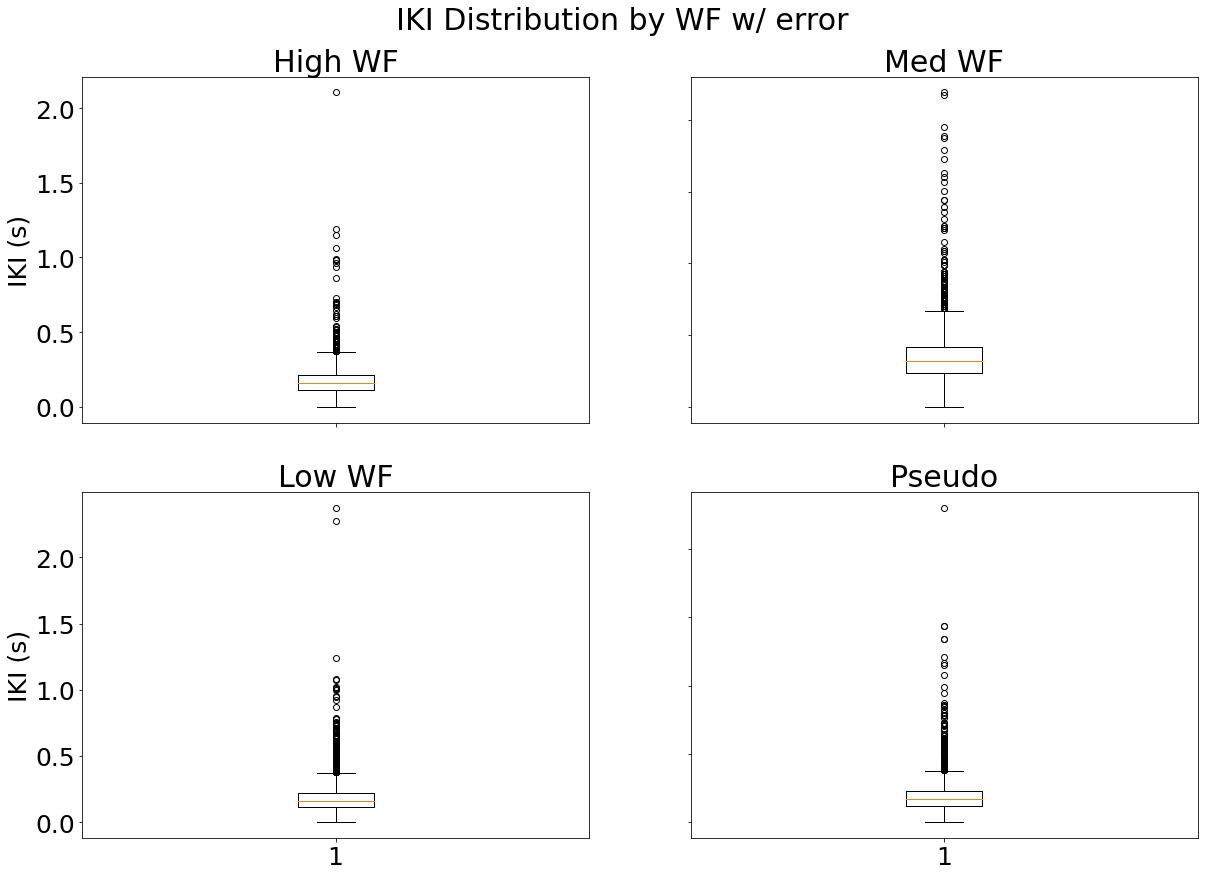

In [11]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot(highwf_ikis)
axs[0, 0].set_title("High WF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medwf_ikis)
axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowwf_ikis)
axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1])
axs[1, 1].boxplot(pseudo_ikis)
axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

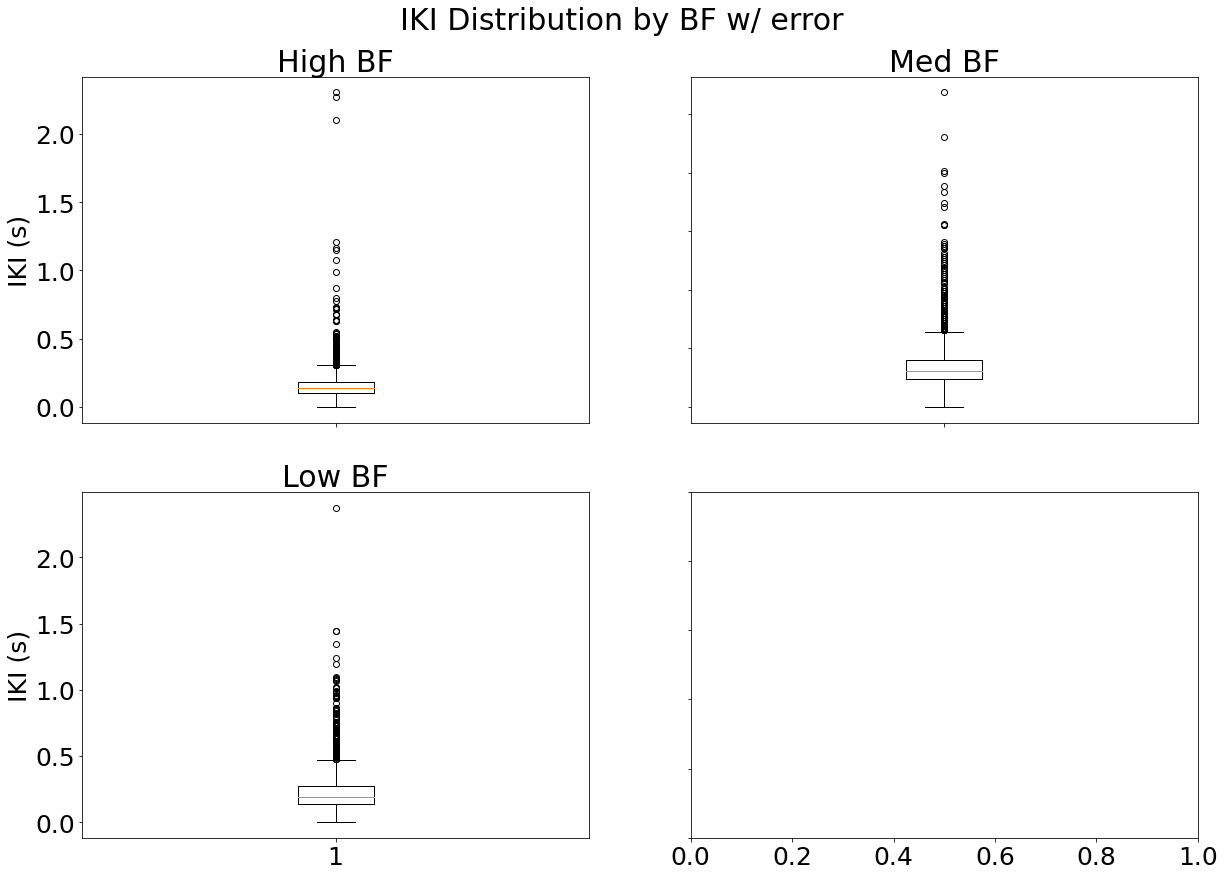

In [12]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot(highbf_ikis)
axs[0, 0].set_title("High BF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medbf_ikis)
axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowbf_ikis)
axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

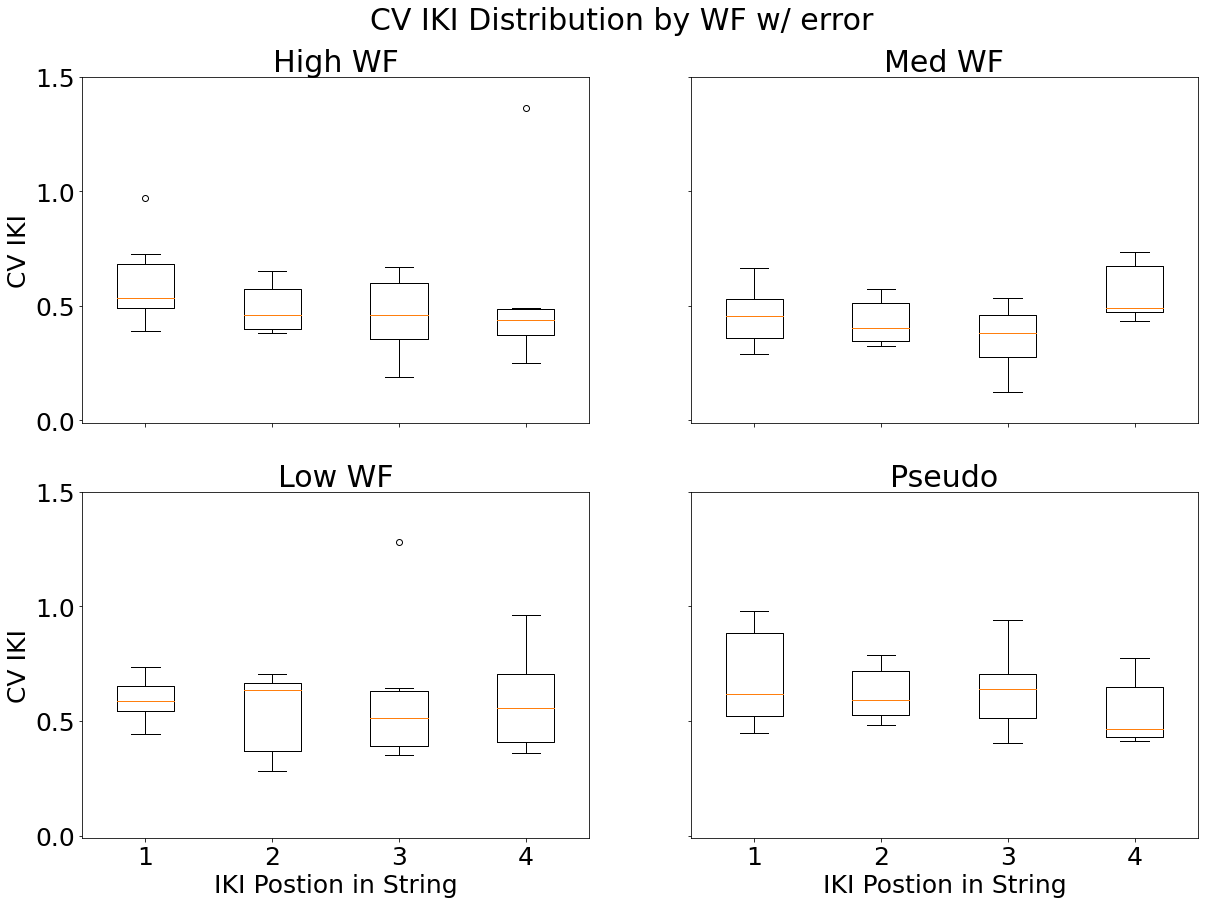

In [13]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High WF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med WF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low WF")
axs[1, 0].set_ylim([-0.01, 1.5])
axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
axs[1, 1].set_title("Pseudo")
axs[1, 1].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

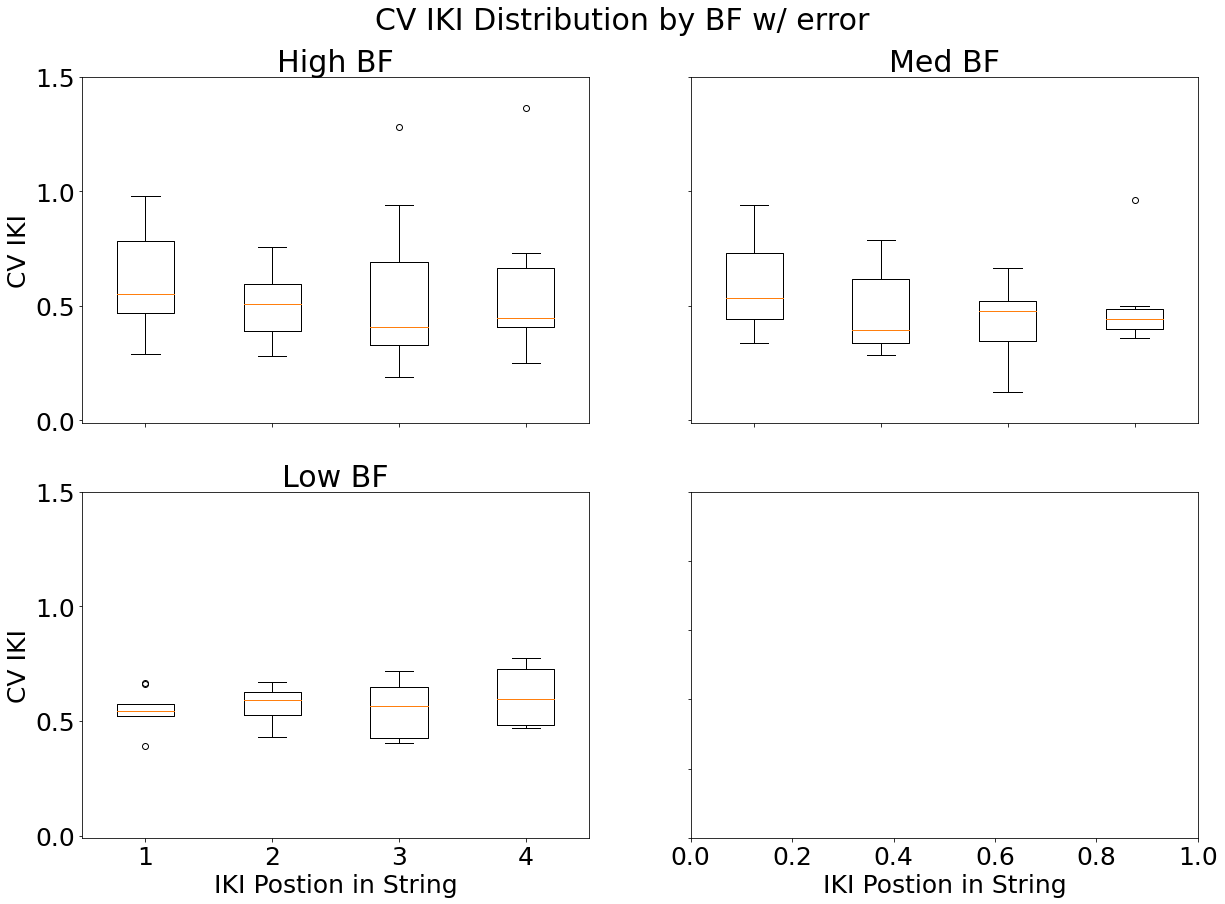

In [14]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highbf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High BF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medbf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med BF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowbf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low BF")
axs[1, 0].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [15]:
## defining function for finding CV IKI avg for each individual
def avgcv_bysub(word_type, DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        sub_avg = typ.avg_cv(word_type, sub_data)
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg CV 1', 'Avg CV 2', 'Avg CV 3', 'Avg CV 4'])
    return sub_avgs

## defining function for finding Avg IKI for each individual
def avgposiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        sub_avg = []
        ikis.iloc[:, 1:5].mean()
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI 1', 'Avg IKI 2', 'Avg IKI 3', 'Avg IKI 4'])
    return sub_avgs

def avgiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        iki_list = pd.concat([ikis[1], ikis[2], ikis[3], ikis[4]], ignore_index=True)
        sub_avg = []
        sub_avg.append(np.mean(iki_list))
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
    return sub_avgs

# def avgiki_bysub_bg(DF):
#     sub_avgs =[]
#     for sub in ID_list:
#         sub_data = pd.DataFrame()
#         for index, data in DF.iterrows():
#             if DF.loc[index, 'sID'] == sub:
#                 sub_data = sub_data.append(DF.loc[index], ignore_index=True)
#         sub_avg = []
#         sub_avg.append(np.mean(sub_data['IKI']))
#         sub_avg.insert(0, sub)
#         sub_avgs.append(sub_avg)
#     sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
#     return sub_avgs

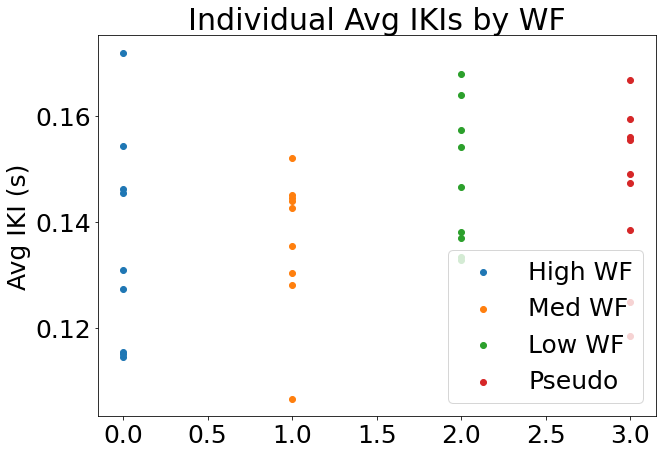

In [20]:
plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(([0] * len((avgiki_bysub(highwf_rts)).iloc[:, 1])), avgiki_bysub(highwf_rts).iloc[:, 1], label='High WF')
medwf_scatter = plt.scatter(([1] * len((avgiki_bysub(medwf_rts)).iloc[:, 1])), avgiki_bysub(medwf_rts).iloc[:, 1], label='Med WF')
lowwf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowwf_rts)).iloc[:, 1])), avgiki_bysub(lowwf_rts).iloc[:, 1], label='Low WF')
pseudo_scatter = plt.scatter(([3] * len((avgiki_bysub(pseudo_rts)).iloc[:, 1])), avgiki_bysub(pseudo_rts).iloc[:, 1], label='Pseudo')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by WF")
plt.legend(loc= "best")

plt.show()

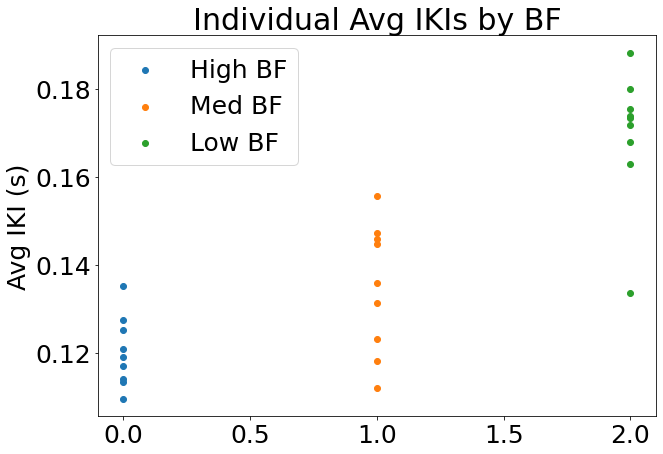

In [21]:
plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter(([0] * len((avgiki_bysub(highbf_rts)).iloc[:, 1])), avgiki_bysub(highbf_rts).iloc[:, 1], label='High BF')
medbf_scatter = plt.scatter(([1] * len((avgiki_bysub(medbf_rts)).iloc[:, 1])), avgiki_bysub(medbf_rts).iloc[:, 1], label='Med BF')
lowbf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowbf_rts)).iloc[:, 1])), avgiki_bysub(lowbf_rts).iloc[:, 1], label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

In [22]:
bg_freqs = pd.read_csv('bg_freqs.csv').drop(labels=['Unnamed: 0'], axis=1)
bg_freqs = bg_freqs.sort_values(by='Frequency', ascending=False, ignore_index=True)
# bg_freqs

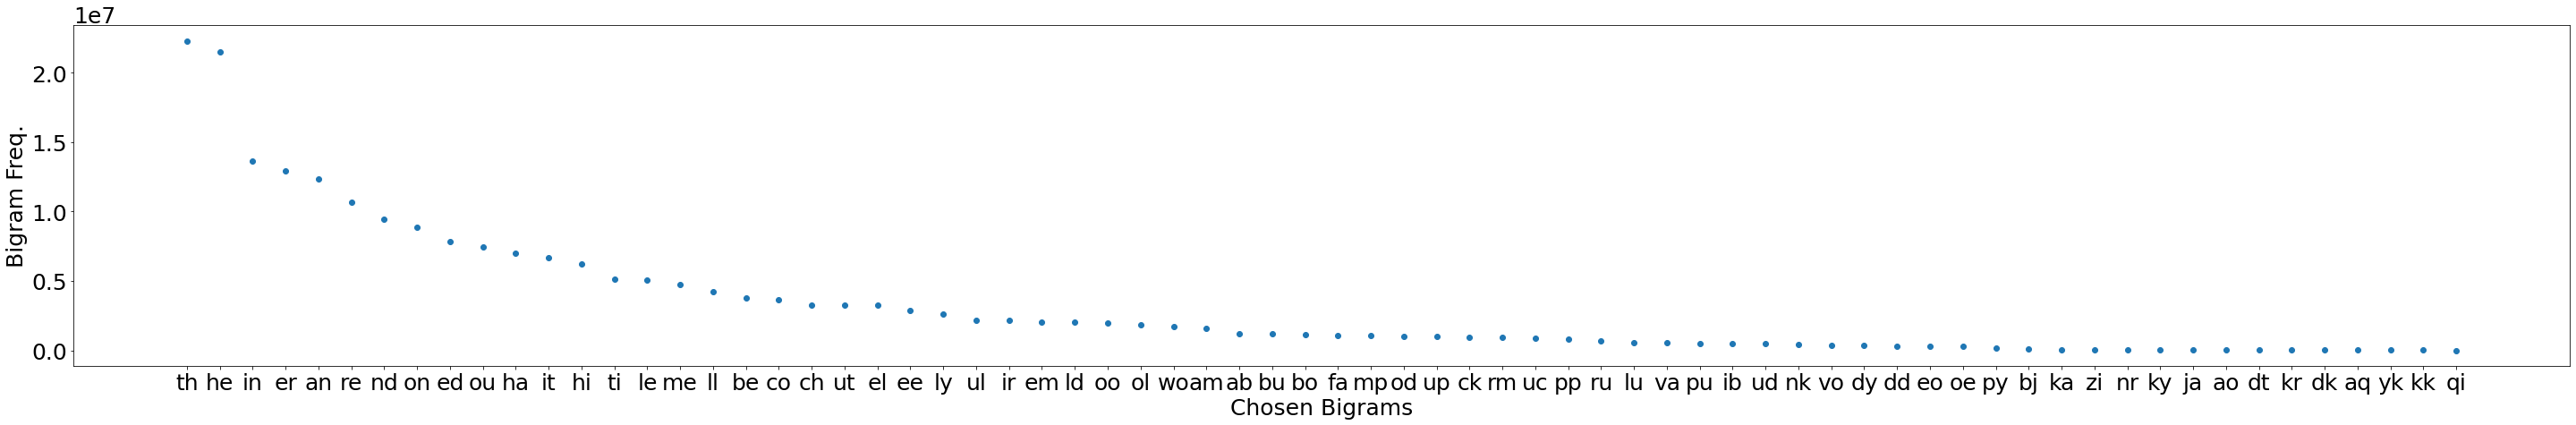

In [23]:
plt.figure(figsize=(50, 7))
bg_freq = plt.scatter(bg_freqs['Bigrams'], bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [24]:
## defining function to organize bigram ikis
def bg_iki_sort(DF, sort_parameter): # DF is all_bgs or corr_bgs, sort_parameter is relevant list of strings
    bg_ikis = []
    bg_strings = []
    for bg in bg_freqs['Bigrams']:
        ikis = [bg]
        strings = [bg]
        for index, data in DF.iterrows():
            if ((DF['Bigram'][index]).replace("'", "")).replace(" ", "") == bg and DF['string'][index] in sort_parameter:
                ikis.append(DF['IKI'][index])
                strings.append(DF['string'][index])
        bg_ikis.append(ikis)
        bg_strings.append(strings)
            
    return pd.DataFrame(bg_ikis)
#     bg_strings = pd.DataFrame(bg_strings)

In [25]:
bg_ikis = []
bg_strings = []
for bg in bg_freqs['Bigrams']:
    ikis = [bg]
    strings = [bg]
    for index, data in corr_bgs.iterrows():
        if corr_bgs['Bigram'][index] == bg:
            ikis.append(corr_bgs['IKI'][index])
            strings.append(corr_bgs['string'][index])
    bg_ikis.append(ikis)
    bg_strings.append(strings)
    
            
bg_ikis = pd.DataFrame(bg_ikis)
bg_strings = pd.DataFrame(bg_strings)

bg_xvals = []
for n in range(0,70):
    bg_xvals.append([n]*577)
    
bg_xvals = pd.DataFrame(bg_xvals)

In [26]:
bg_stats = []
for index, data in bg_ikis.iterrows():
    bg_stats.append([bg_ikis.iloc[index, 0], bg_ikis.iloc[index, 1:577].mean(), np.std(bg_ikis.iloc[index, 1:577]), variation((bg_ikis.iloc[index, 1:577].tolist()), nan_policy='omit')])
    
bg_stats = pd.DataFrame(bg_stats, columns=['Bigram', 'Mean', 'STD', 'CV'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(bg_stats)

   Bigram      Mean       STD        CV
0      th  0.130711  0.077565  0.593410
1      he  0.137860  0.068478  0.496719
2      in  0.193118  0.030664  0.158782
3      er  0.140287  0.061804  0.440550
4      an  0.183309  0.074115  0.404319
5      re  0.151945  0.163529  1.076238
6      nd  0.143707  0.054473  0.379055
7      on  0.222223  0.095847  0.431311
8      ed  0.211229  0.172769  0.817925
9      ou  0.172296  0.074447  0.432089
10     ha  0.161576  0.095915  0.593622
11     it  0.149598  0.073536  0.491560
12     hi  0.180678  0.094456  0.522784
13     ti  0.146592  0.070205  0.478914
14     le  0.095721  0.031994  0.334237
15     me  0.124297  0.083608  0.672646
16     ll  0.153481  0.019197  0.125080
17     be  0.146130  0.062301  0.426343
18     co  0.206588  0.105916  0.512691
19     ch  0.141854  0.044478  0.313545
20     ut  0.119623  0.043682  0.365165
21     el  0.222328  0.075001  0.337344
22     ee  0.162921  0.039336  0.241441
23     ly  0.171729  0.086192  0.501909


In [27]:
def bgplot_bystr():
    for string in typ.all_strings:
        s = bg_strings[bg_strings.isin([string])].stack()
        L = s.index.tolist()
        xvals = []
        ikis = []
        for i in L:
            xvals.append(bg_xvals.iloc[i])
            ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

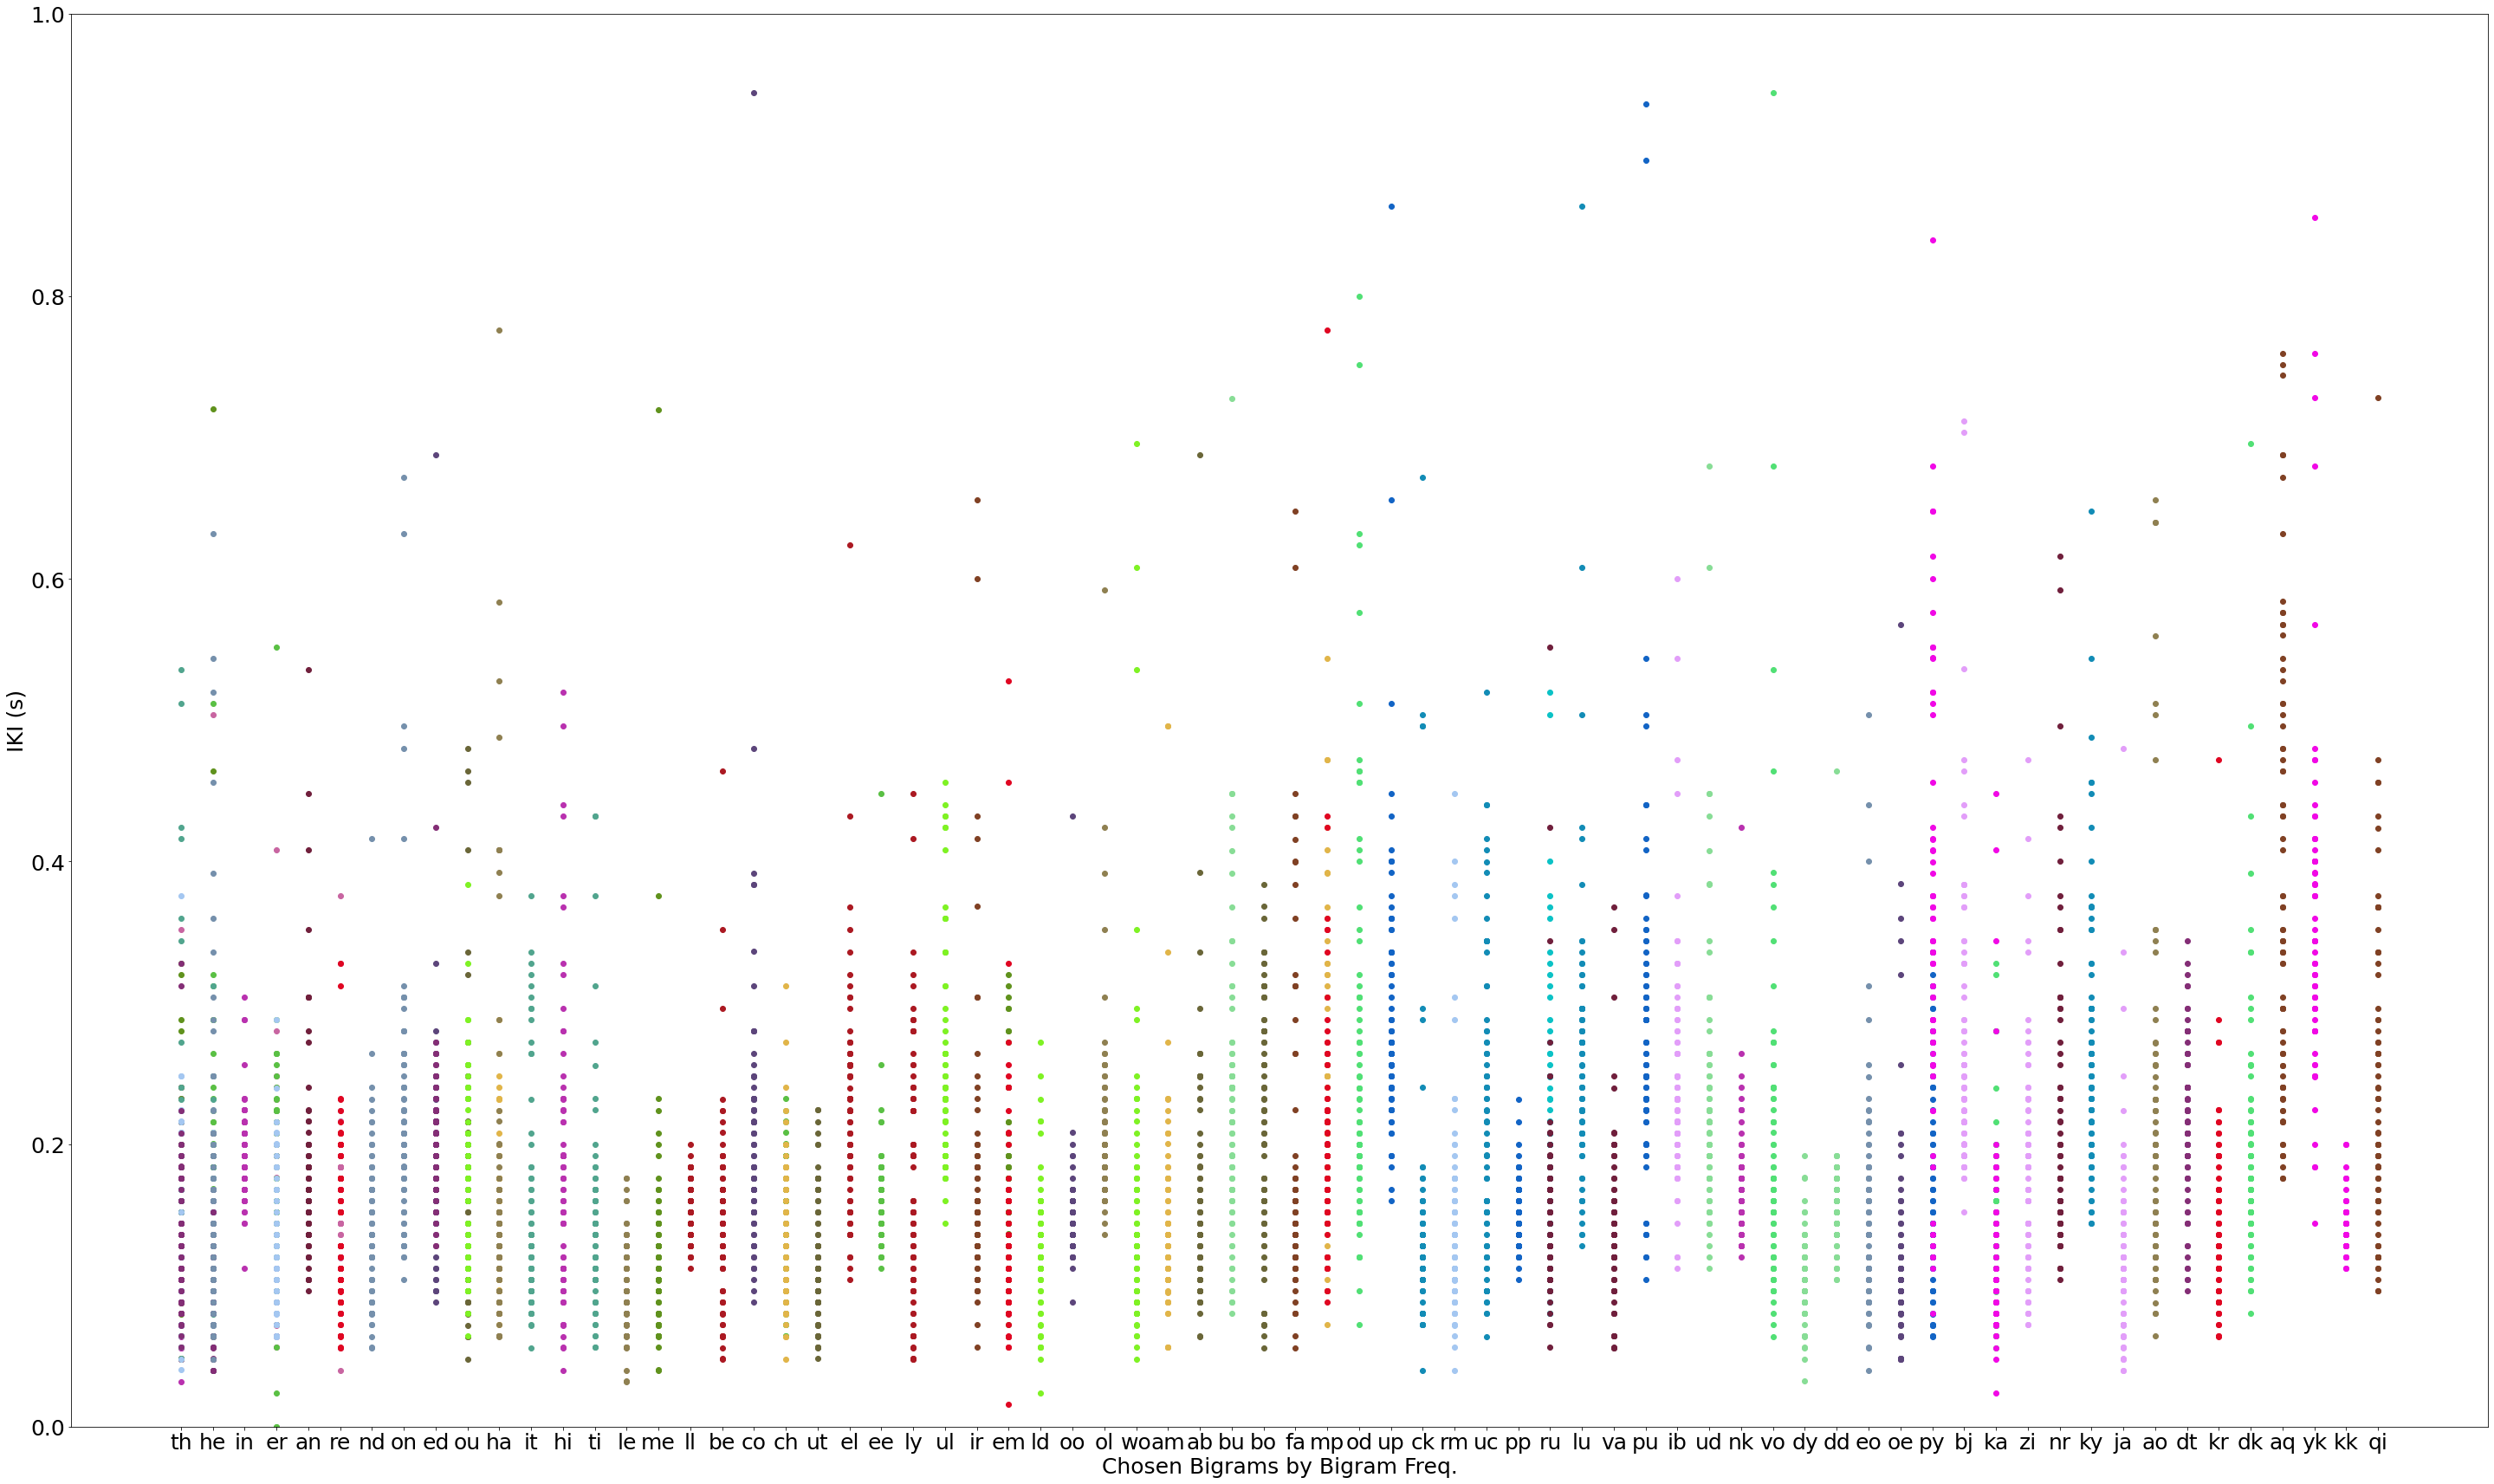

In [28]:
## scatter of iki values by bigram and word(color)
plt.figure(figsize=(50, 30))

for string in typ.all_strings:
    s = bg_strings[bg_strings.isin([string])].stack()
    L = s.index.tolist()
    xvals = []
    ikis = []
    for i in L:
        xvals.append(bg_xvals.iloc[i])
        ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

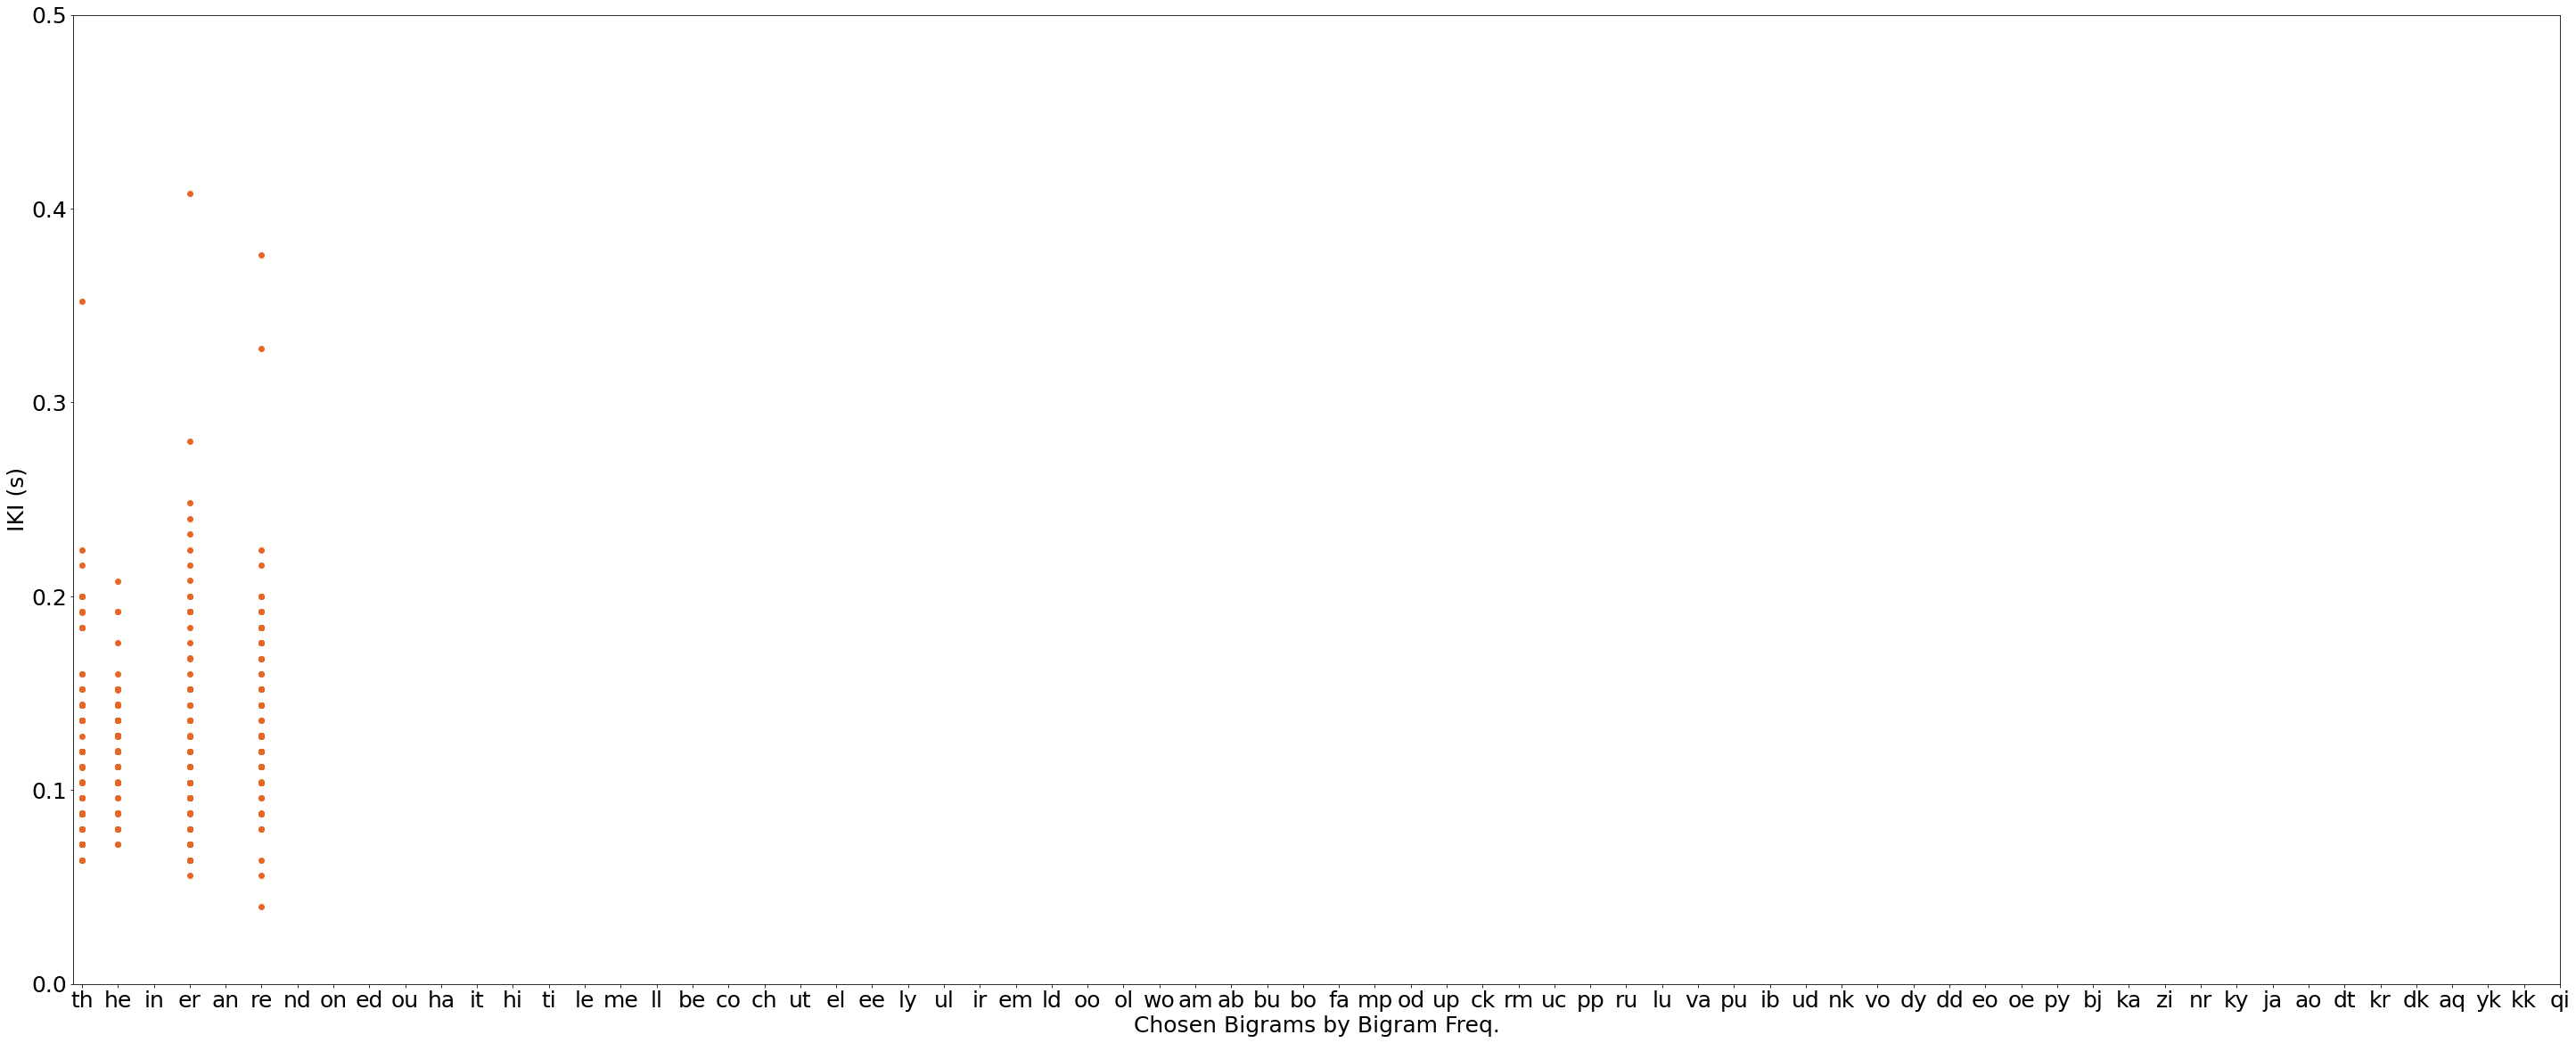

In [29]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'there'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 0.5])
# plt.ylim([0.04775, 0.04825])

plt.show()

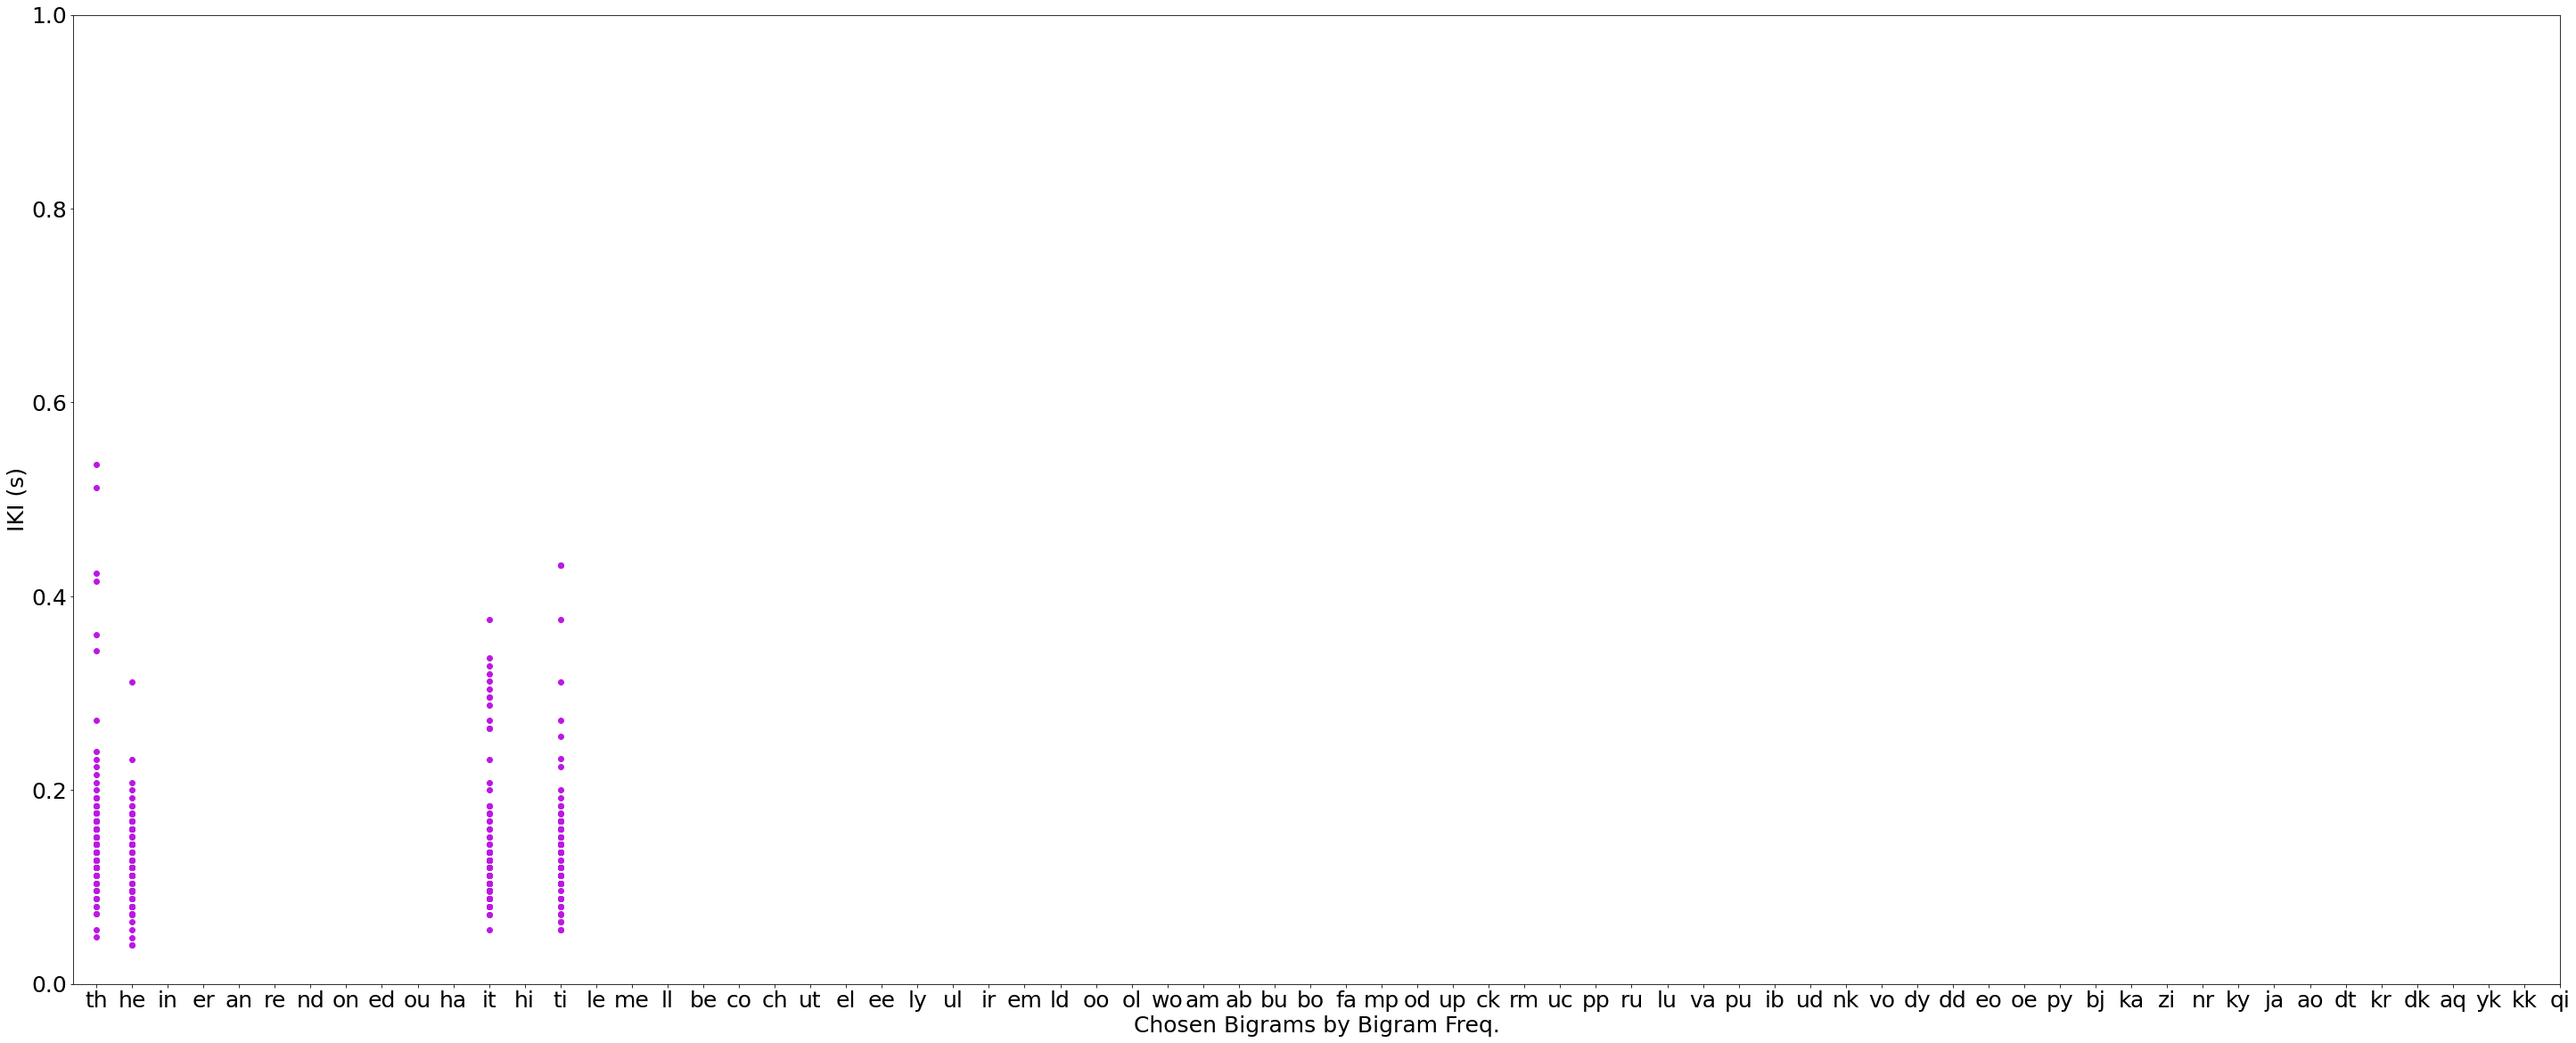

In [30]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'tithe'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [31]:
# ## plot scatter for each wf type and color
# plt.figure(figsize=(50, 20))

# for freq in typ.wf_types:
#     s = bg_wfreqs[bg_wfreqs.isin([freq])].stack()
#     L = s.index.tolist()
#     xvals = []
#     ikis = []
#     for i in L:
#         xvals.append(bg_xvals.iloc[i])
#         ikis.append(bg_ikis.iloc[i])
#     rbg = np.random.rand(3,).reshape(1,-1)
#     plt.scatter(xvals, ikis, c=rbg)

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_freqs['Bigrams'])

# plt.show()

In [33]:
th_there = all_bigrams[all_bigrams['string'] == 'there']
th_there = th_there[th_there['Bigram'] == 'th']

th_theme = all_bigrams[all_bigrams['string'] == 'theme']
th_theme = th_theme[th_theme['Bigram'] == 'th']

th_think = all_bigrams[all_bigrams['string'] == 'think']
th_think = th_think[th_think['Bigram'] == 'th']

th_therm = all_bigrams[all_bigrams['string'] == 'therm']
th_therm = th_therm[th_therm['Bigram'] == 'th']

In [477]:
def indiv_means(string, bigram):
    means = pd.DataFrame()
    DF = tight_bgs[tight_bgs['string'] == string]
    DF = DF[DF['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        means = means.append({'ID':sID, 'String':string, 'Bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return means

def indiv_cvs(string, bigram):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs['string'] == string]
    DF = DF[DF['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'String':string, 'Bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

In [286]:
def indiv_means_bgtype(bg_type):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs.string.isin(bg_type)]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return cvs

def indiv_cvs_bgtype(bg_type):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs.string.isin(bg_type)]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

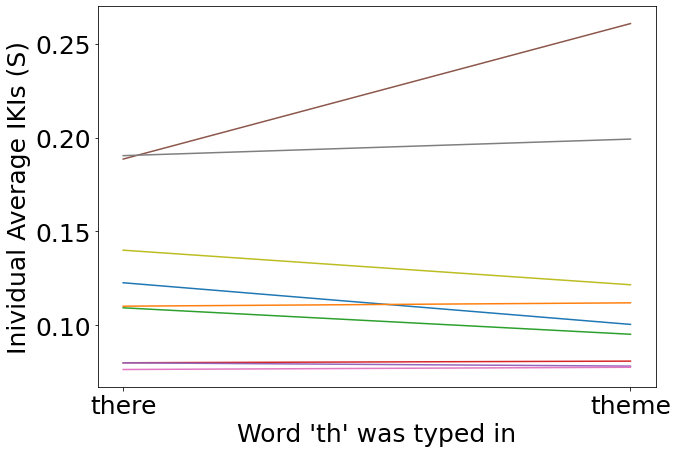

In [298]:
x = [2, 4]
D = (indiv_means('there', 'th')['Avg IKI'], indiv_means('theme', 'th')['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

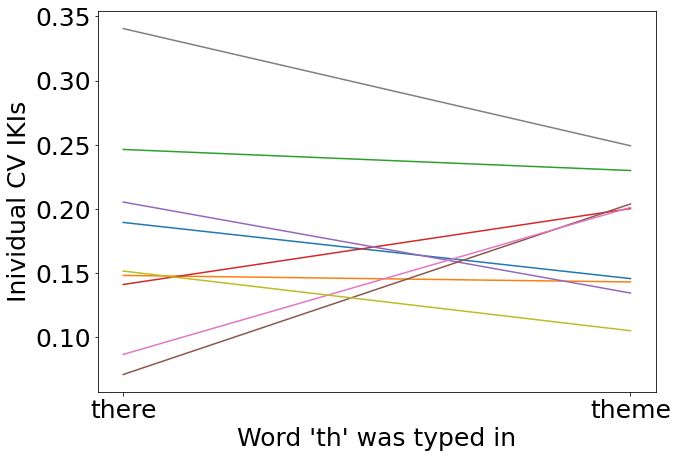

In [299]:
x = [2, 4]
D = (indiv_cvs('there', 'th')['CV IKI'], indiv_cvs('theme', 'th')['CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

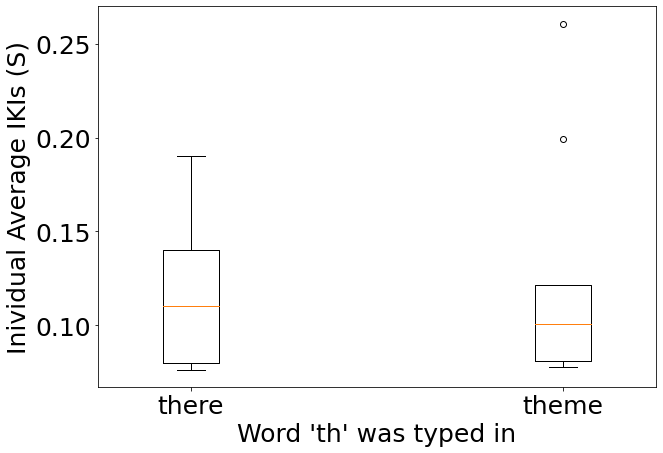

In [300]:
x = [2, 4]
D = (indiv_means('there', 'th')['Avg IKI'], indiv_means('theme', 'th')['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

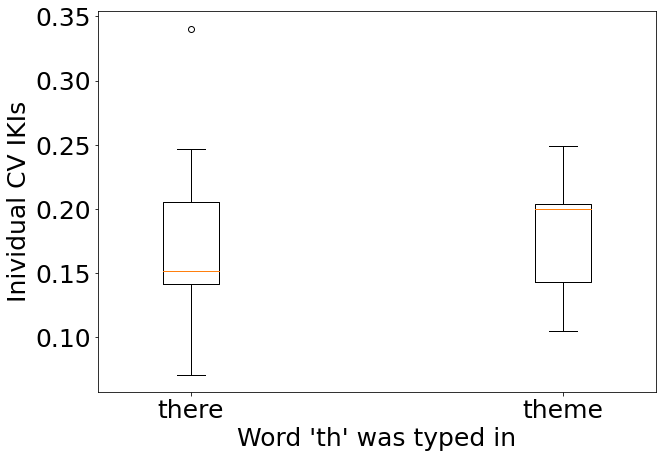

In [301]:
x = [2, 4]
D = (indiv_cvs('there', 'th')['CV IKI'], indiv_cvs('theme', 'th')['CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

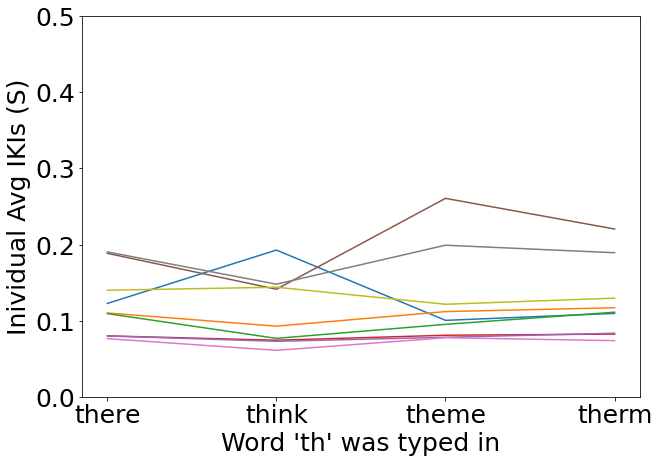

In [331]:
x = [2, 4, 6, 8]
D = (indiv_means('there', 'th')['Avg IKI'], indiv_means('think', 'th')['Avg IKI'], 
     indiv_means('theme', 'th')['Avg IKI'], indiv_means('therm', 'th')['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

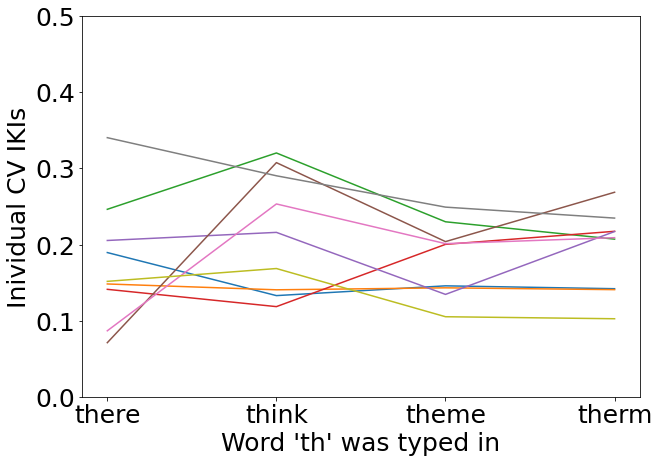

In [302]:
x = [2, 4, 6, 8]
D = (indiv_cvs('there', 'th')['CV IKI'], indiv_cvs('think', 'th')['CV IKI'], indiv_cvs('theme', 'th')['CV IKI'], indiv_cvs('therm', 'th')['CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

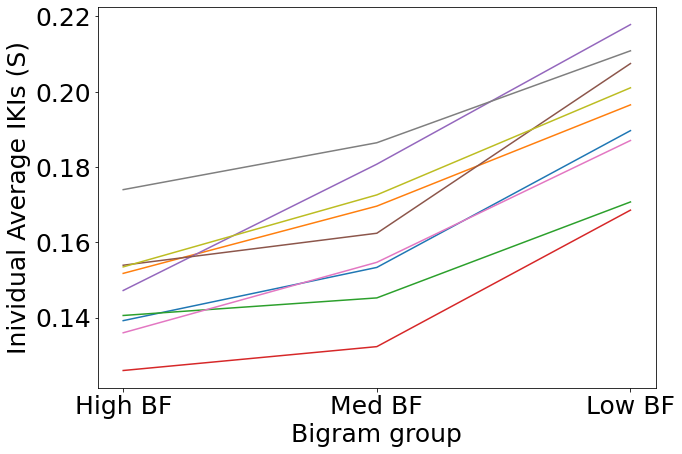

In [517]:
x = [2, 4, 6]
D = (indiv_means_bgtype(typ.highbf)['Avg IKI'], indiv_means_bgtype(typ.medbf)['Avg IKI'], indiv_means_bgtype(typ.lowbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram group")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

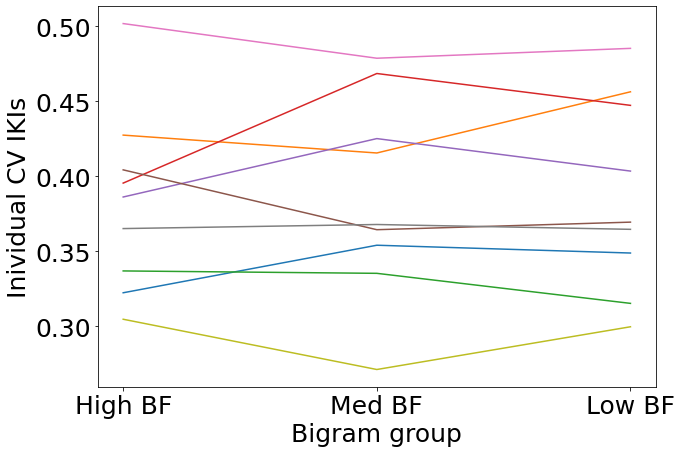

In [518]:
x = [2, 4, 6]
D = (indiv_cvs_bgtype(typ.highbf)['CV IKI'], indiv_cvs_bgtype(typ.medbf)['CV IKI'], indiv_cvs_bgtype(typ.lowbf)['CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram group")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

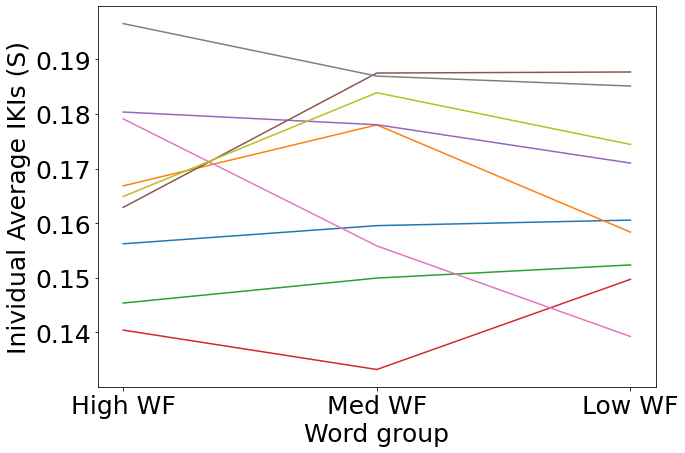

In [519]:
x = [2, 4, 6]
D = (indiv_means_bgtype(typ.highwf)['Avg IKI'], indiv_means_bgtype(typ.medwf)['Avg IKI'], 
     indiv_means_bgtype(typ.lowwf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High WF', 'Med WF', 'Low WF'))
plt.xlabel("Word group")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

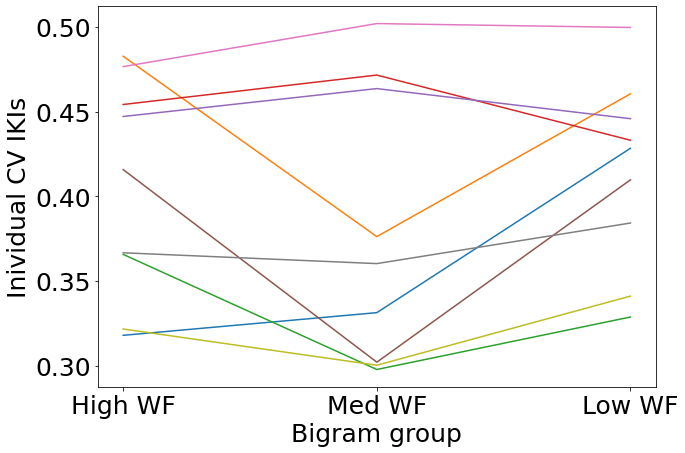

In [520]:
x = [2, 4, 6]
D = (indiv_cvs_bgtype(typ.highwf)['CV IKI'], indiv_cvs_bgtype(typ.medwf)['CV IKI'], 
     indiv_cvs_bgtype(typ.lowwf)['CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High WF', 'Med WF', 'Low WF'))
plt.xlabel("Bigram group")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [460]:
def delta_iki(bigram, string):
    all_deltas = []
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.Bigram == bigram) & (tight_bgs.string == string)]
        deltas = [sub]
        for trial in range(0, len(sub_df) - 1):
            deltas.append(sub_df.iloc[trial + 1, 4] - sub_df.iloc[trial, 4]) ## depends on column position
        all_deltas.append(deltas)
    all_deltas = pd.DataFrame(all_deltas)
    all_deltas = all_deltas.transpose()
    return all_deltas

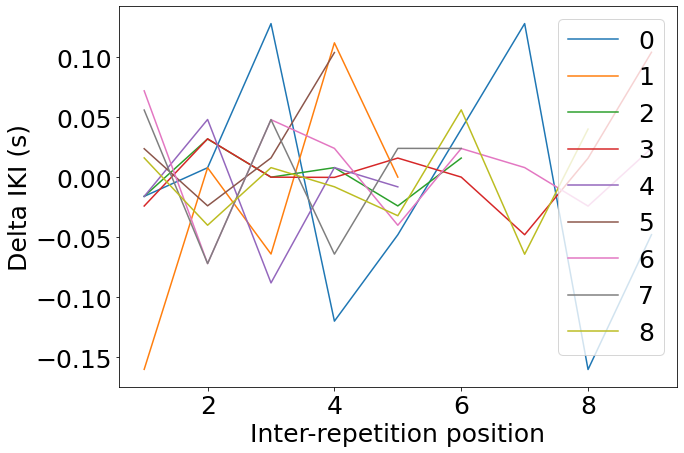

In [463]:
yk_df = delta_iki('pu', 'puppy')[1:]

yk_df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Inter-repetition position")
plt.ylabel("Delta IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend(loc="best")

plt.show()

In [507]:
def indiv_means_bgonly(bigram):
    means = pd.DataFrame()
    DF = tight_bgs[tight_bgs['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        means = means.append({'ID':sID, 'Bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return means

def indiv_cvs_bgonly(bigram):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'Bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

In [509]:
all_indiv_means = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

all_indiv_cvs = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

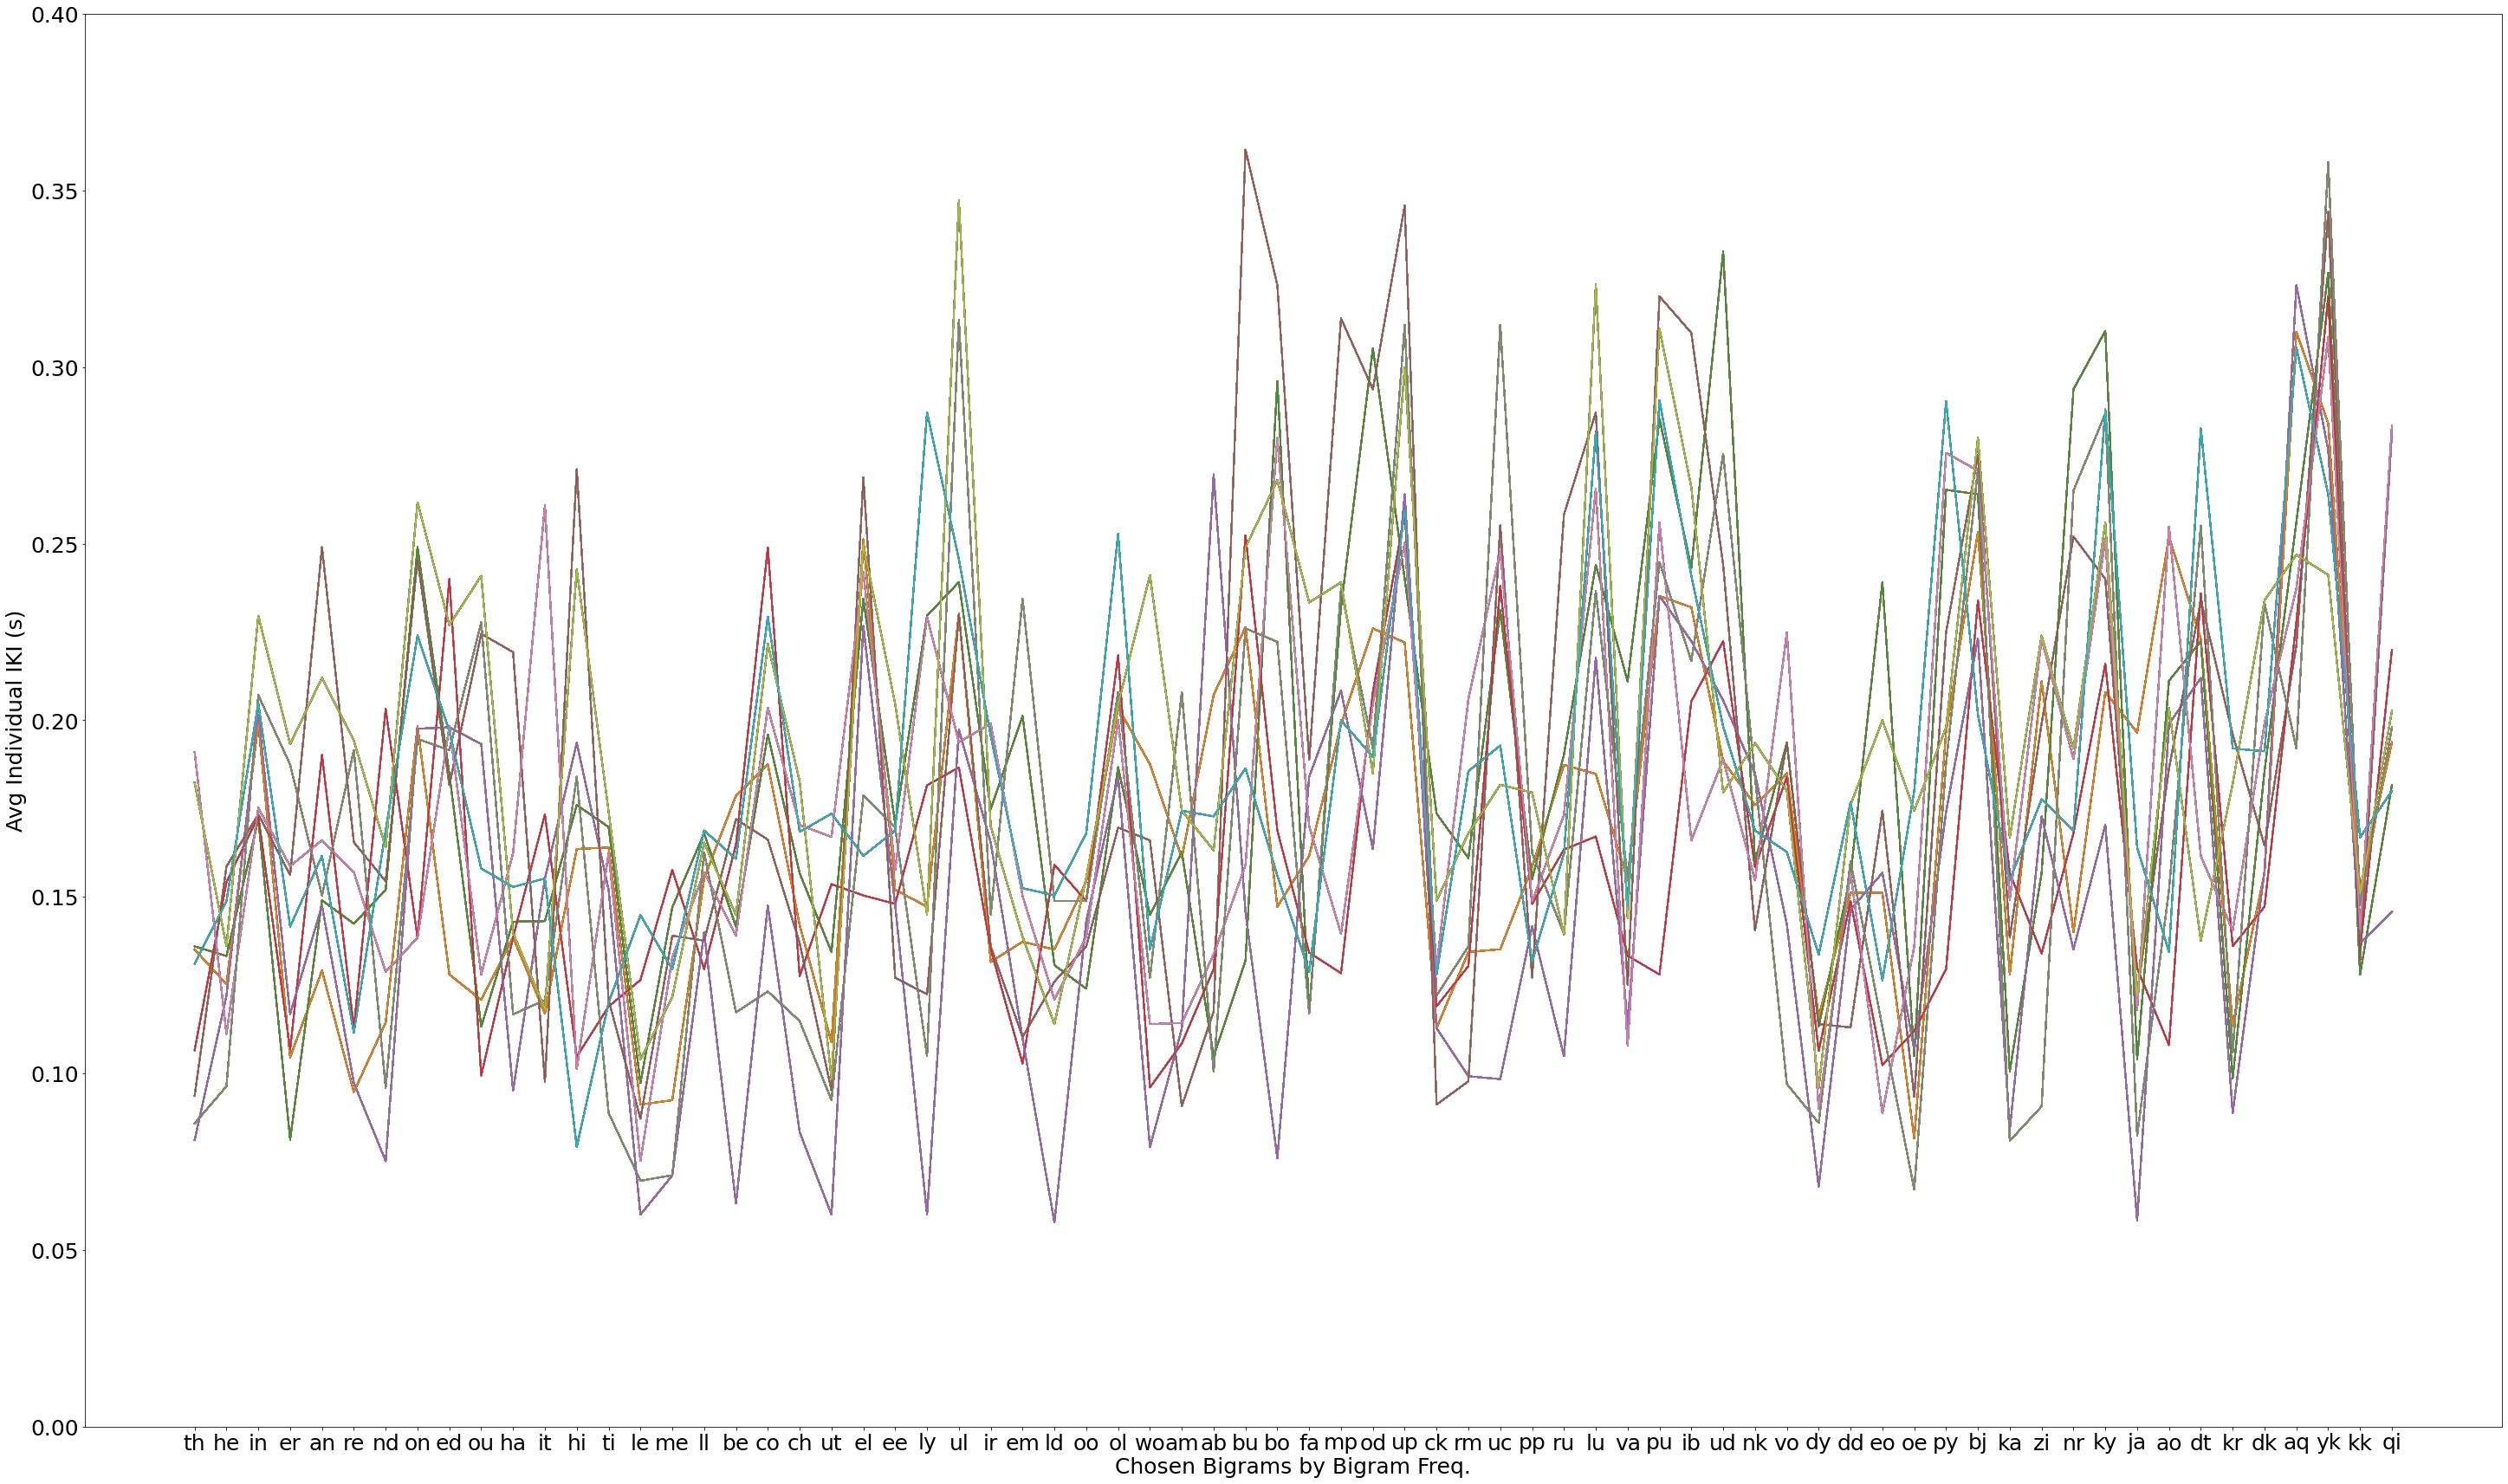

In [512]:
## plot of individual avg iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_means[all_indiv_means.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['Bigram'], bg_df['Avg IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['Bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 0.4])
# plt.ylim([0.04775, 0.04825])

plt.show()

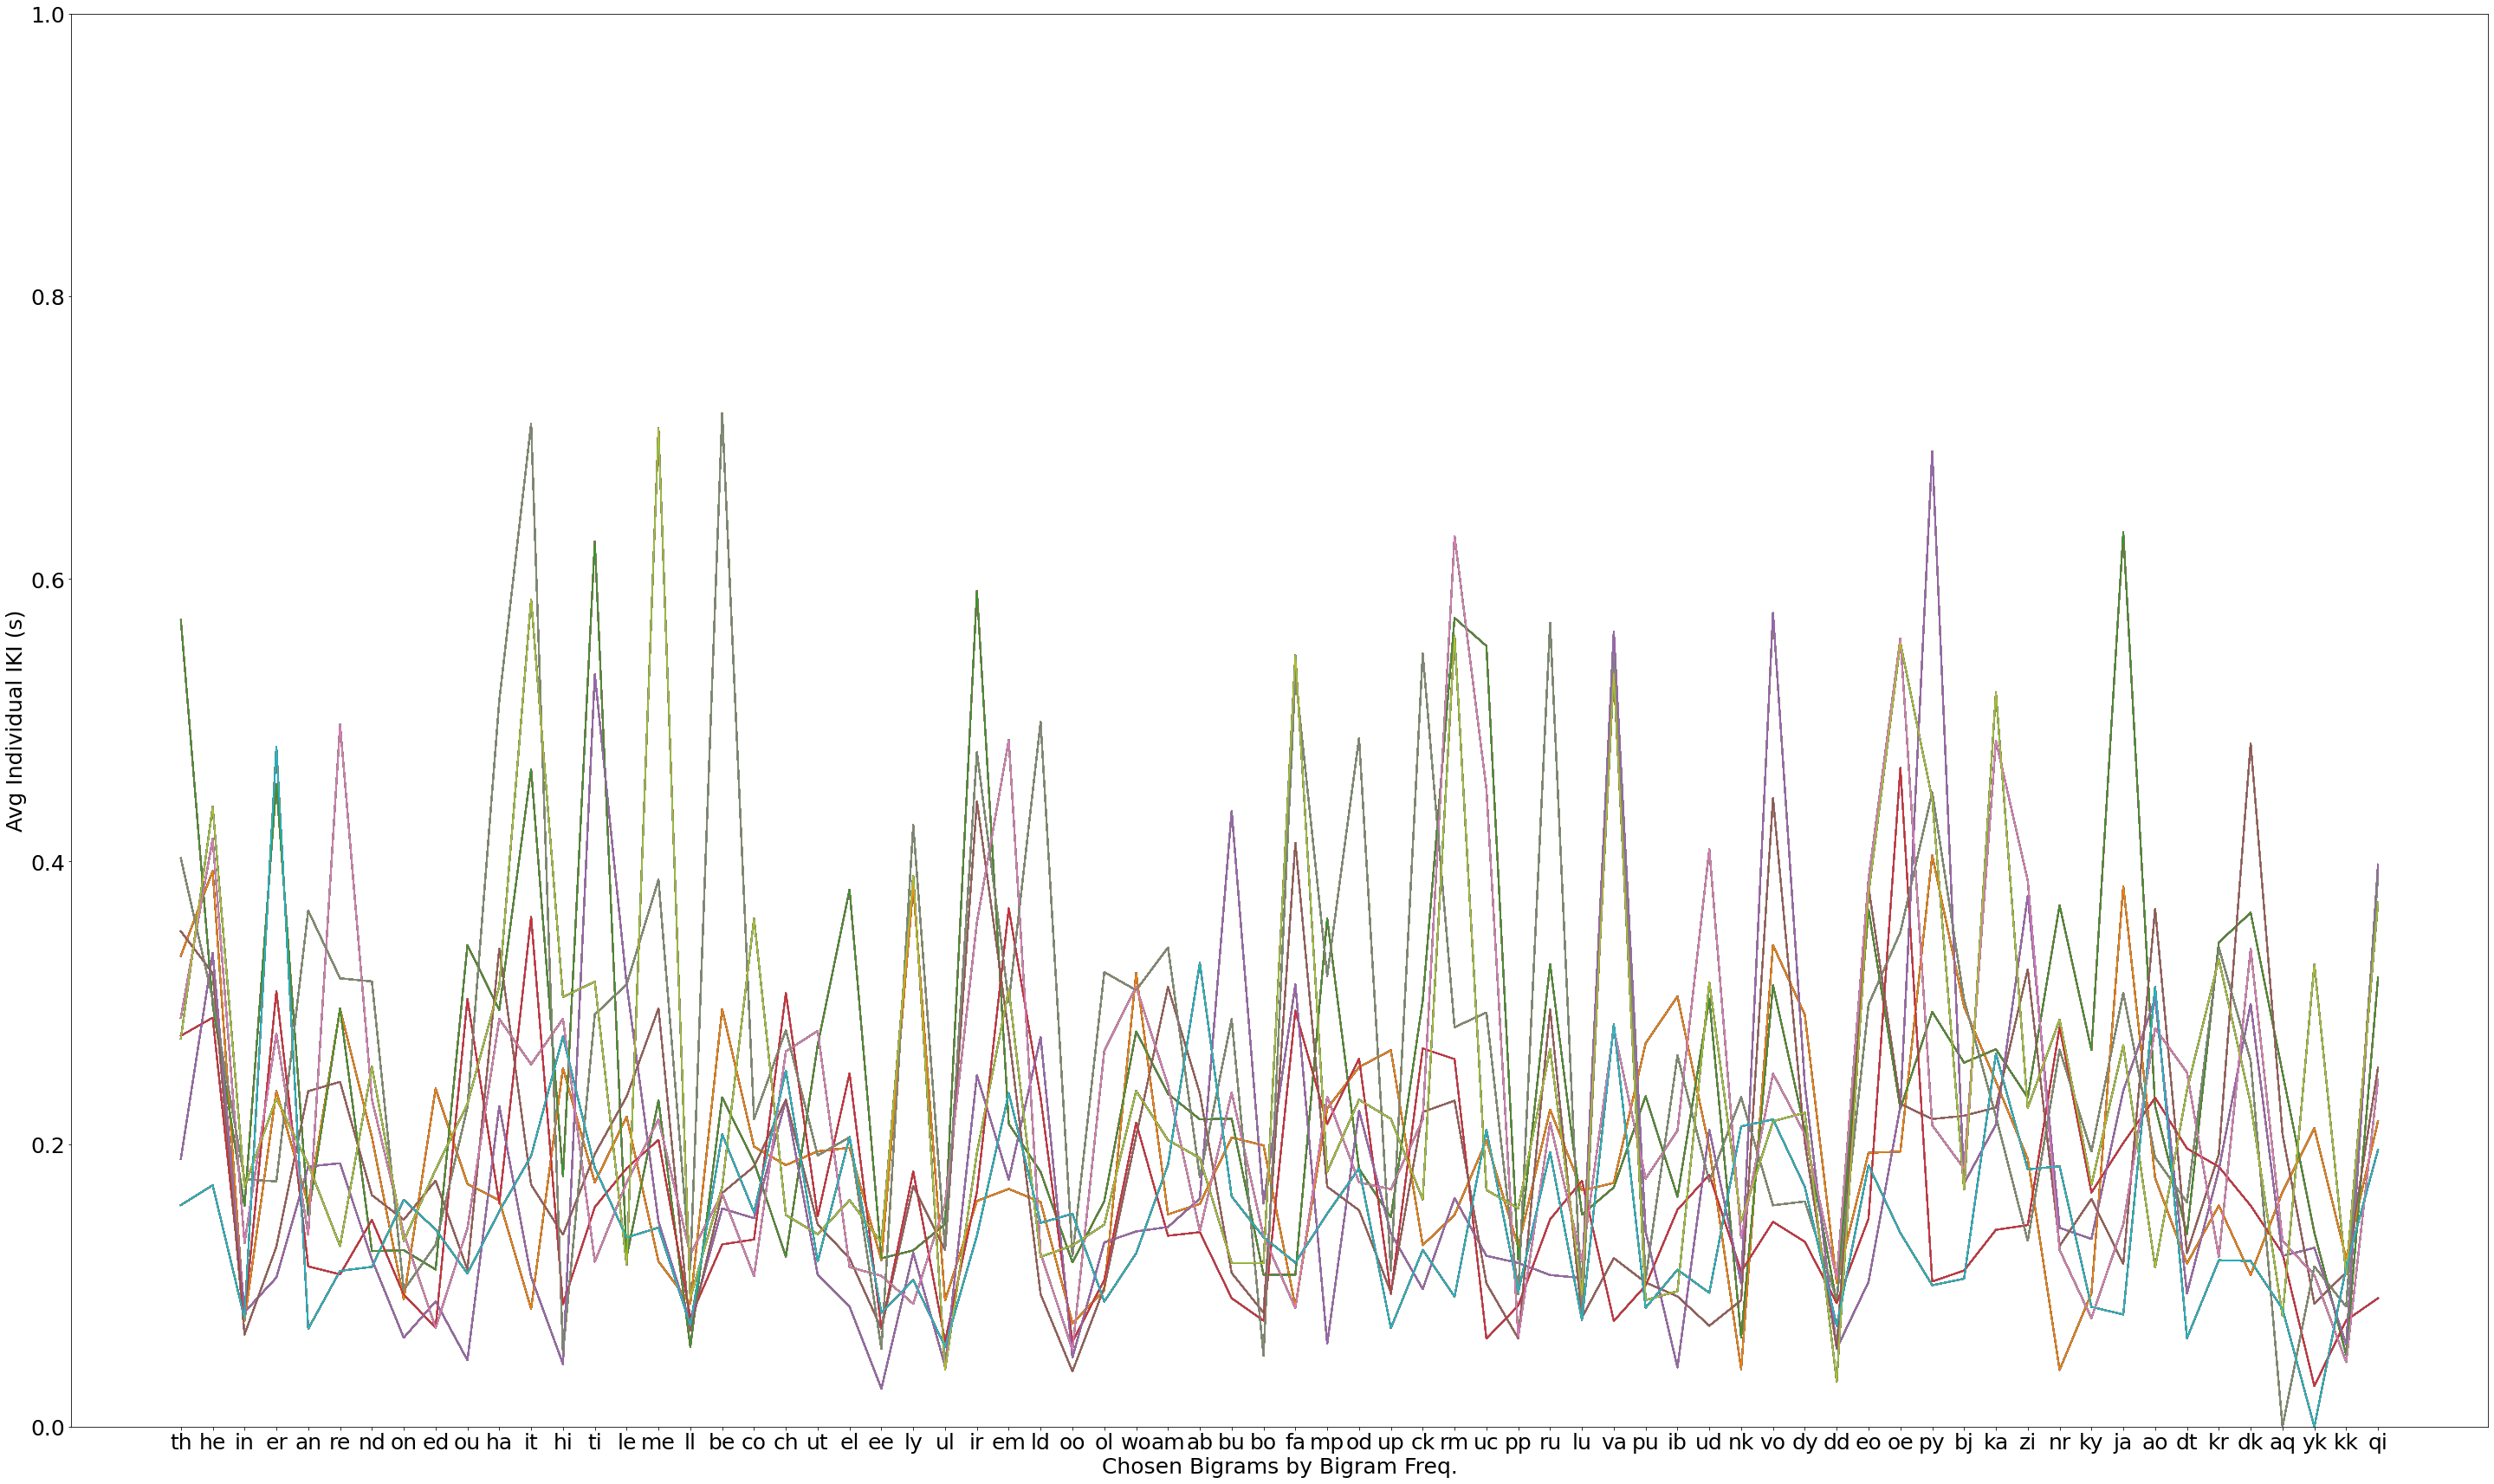

In [515]:
## plot of individual cv iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['Bigram'], bg_df['CV IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['Bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [312]:
th_means = pd.concat([indiv_means('there', 'th'), indiv_means('think', 'th'), indiv_means('theme', 'th'), indiv_means('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
String  0.5518 3.0000 24.0000 0.6518



In [313]:
th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
String  1.0783 3.0000 24.0000 0.3770



In [314]:
th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

               Anova
       F Value Num DF Den DF Pr > F
-----------------------------------
String  1.9732 1.0000 8.0000 0.1977



In [315]:
th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

               Anova
       F Value Num DF Den DF Pr > F
-----------------------------------
String  0.5915 1.0000 8.0000 0.4639



In [316]:
th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

               Anova
       F Value Num DF Den DF Pr > F
-----------------------------------
String  1.2869 1.0000 8.0000 0.2895



In [317]:
th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

               Anova
       F Value Num DF Den DF Pr > F
-----------------------------------
String  0.0659 1.0000 8.0000 0.8039

